# Projet 7 - Implémentez un modèle de scoring

# 1/ Chargement des librairies

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import *

sns.set_style('darkgrid')

# 2/ Chargement du jeu de données avec kernel Kaggle

In [10]:
#Utilisation des fonctions du kernel Kaggle
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype=='object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train(num_rows=None, nan_as_category=False):
    # Read data
    df = pd.read_csv('C:/Users/raflg/Downloads/OpenClassrooms/Projet 7/application_train.csv', nrows=num_rows)
    print(f'Train samples: {len(df)}')
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER']!='XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df, cat_cols

In [11]:
#Création du jeu de données
data, cat_cols = application_train()
data

Train samples: 307511


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,0,1,0,1,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,0,1,0,1,0,NaN,0.267112,72000.0,0.166687,0.044524
307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,1,0,0,1,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,0,1,0,1,0,0.400134,0.462029,85500.0,0.118158,0.054592


# 3/ EDA

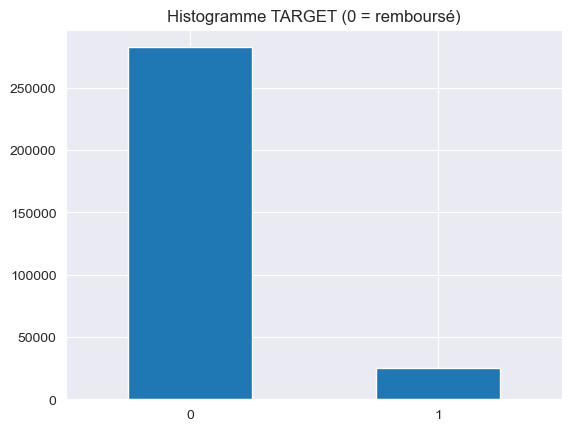

In [12]:
data.TARGET.value_counts().plot(kind='bar')
plt.title('Histogramme TARGET (0 = remboursé)')
plt.xticks(rotation=0)
plt.show()

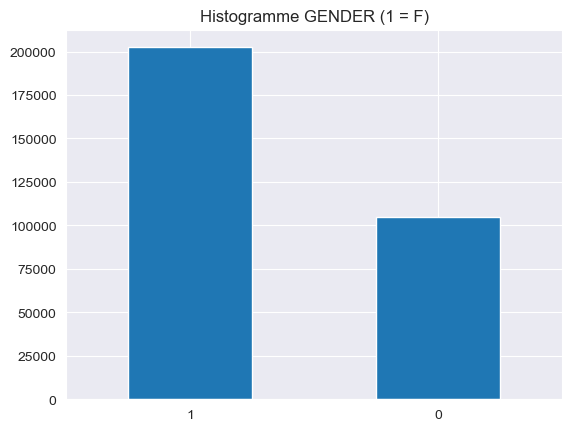

In [13]:
data.CODE_GENDER.value_counts().plot(kind='bar')
plt.title('Histogramme GENDER (1 = F)')
plt.xticks(rotation=0)
plt.show()

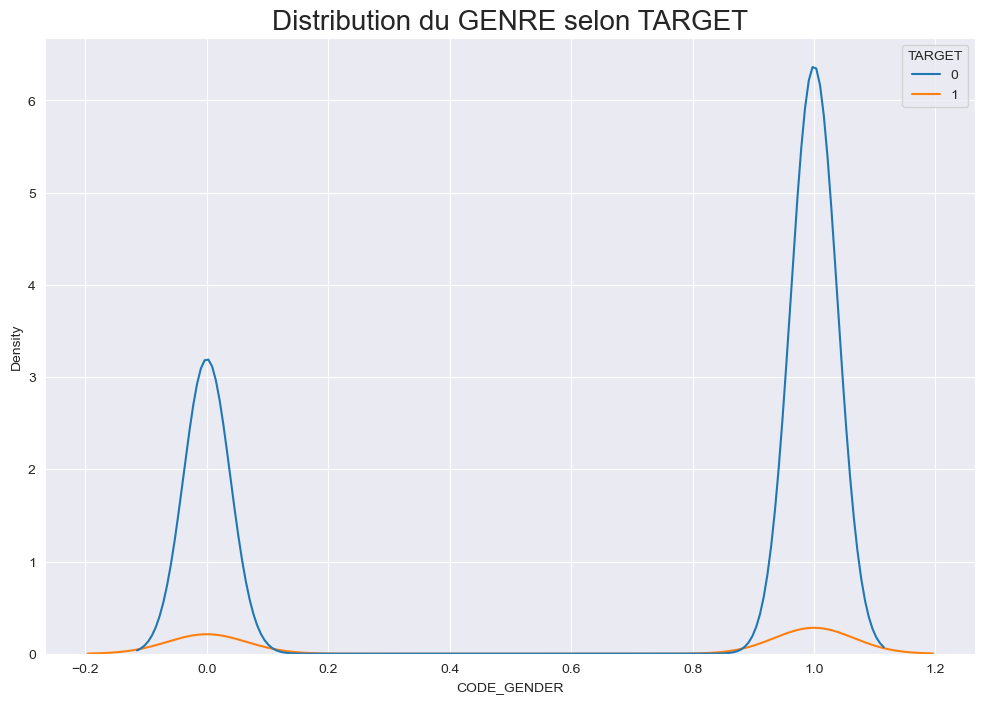

In [14]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data, x='CODE_GENDER', hue='TARGET')
plt.title("Distribution du GENRE selon TARGET", fontsize=20)
plt.show()

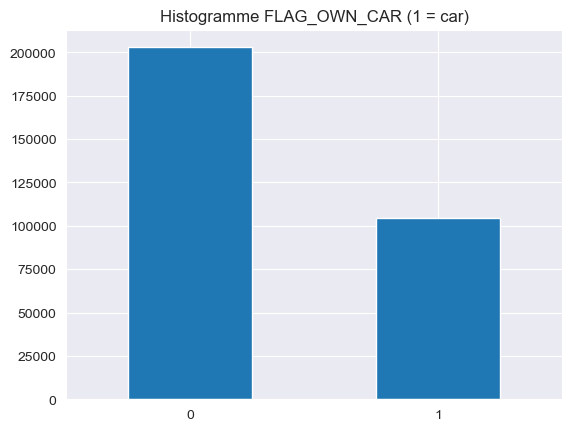

In [15]:
data.FLAG_OWN_CAR.value_counts().plot(kind='bar')
plt.title('Histogramme FLAG_OWN_CAR (1 = car)')
plt.xticks(rotation=0)
plt.show()

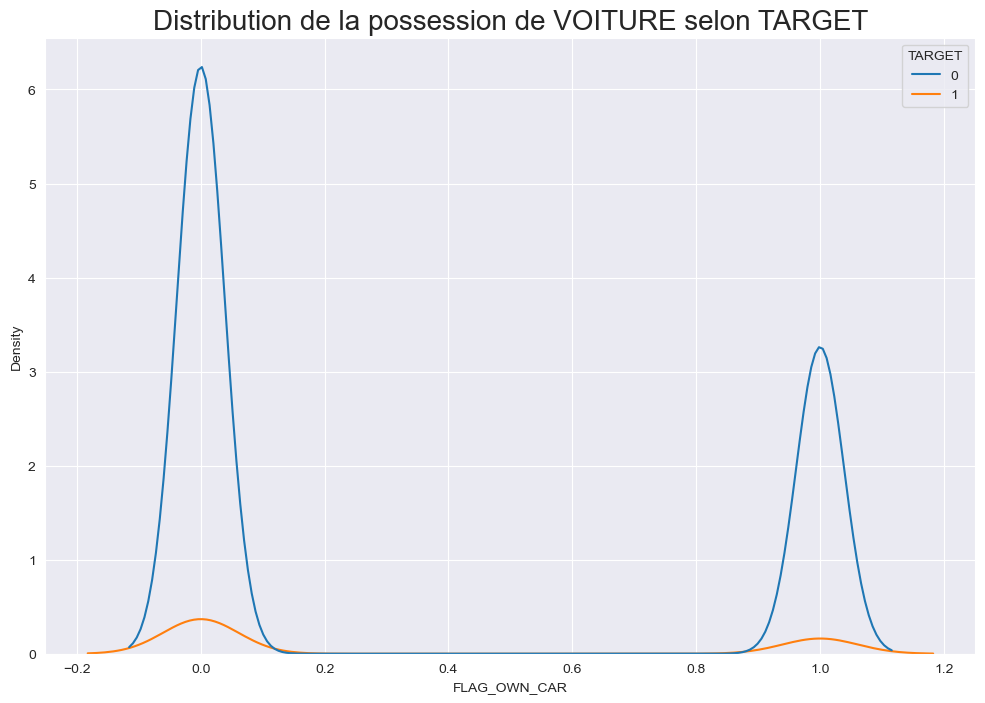

In [16]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data, x='FLAG_OWN_CAR', hue='TARGET')
plt.title("Distribution de la possession de VOITURE selon TARGET", fontsize=20)
plt.show()

In [17]:
#Recherche de NaN pour la variable de possession de véhicule
data.FLAG_OWN_CAR.value_counts(dropna=False)

0    202922
1    104585
Name: FLAG_OWN_CAR, dtype: int64

In [18]:
#Constatation que la variable d'âge du véhicule est NaN si le client n'a pas de véhicule
data[data['FLAG_OWN_CAR']==0]['OWN_CAR_AGE'].value_counts(dropna=False)

NaN    202922
Name: OWN_CAR_AGE, dtype: int64

In [19]:
#Attribution 0 à l'âge de la voiture aux clients sans voiture
data.loc[data['FLAG_OWN_CAR']==0, 'OWN_CAR_AGE'] = 0

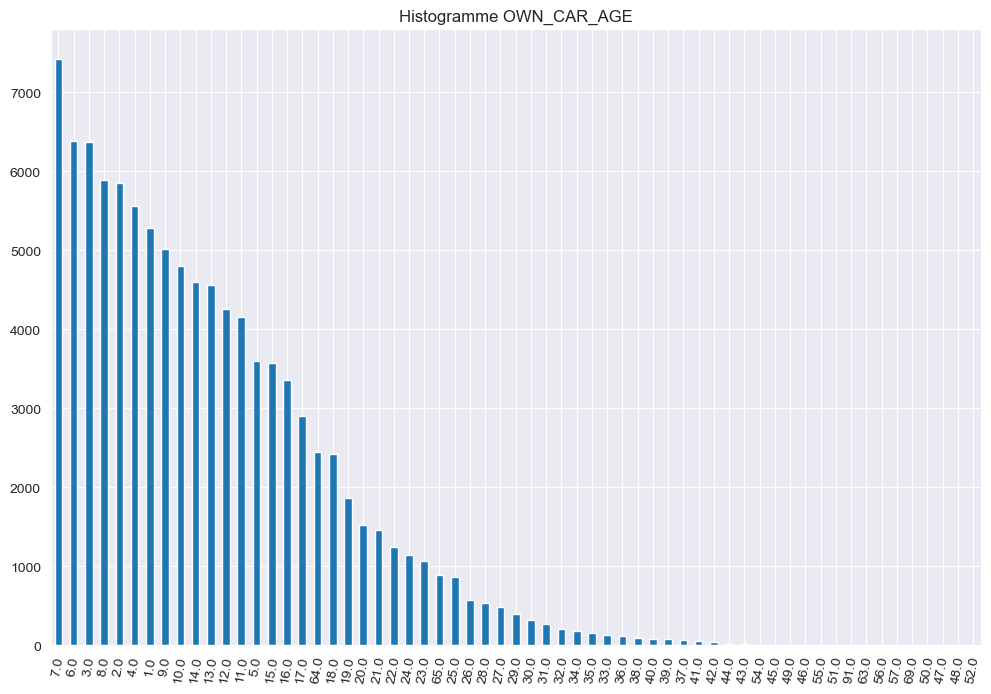

In [20]:
plt.figure(figsize=(12, 8))
data[data['OWN_CAR_AGE']!=0]['OWN_CAR_AGE'].value_counts().plot(kind='bar')
plt.title('Histogramme OWN_CAR_AGE')
plt.xticks(rotation=80)
plt.show()

In [21]:
#Conversion de DAYS_BIRTH en années
data['DAYS_BIRTH'] = np.round(abs(data['DAYS_BIRTH']) /365, 0)

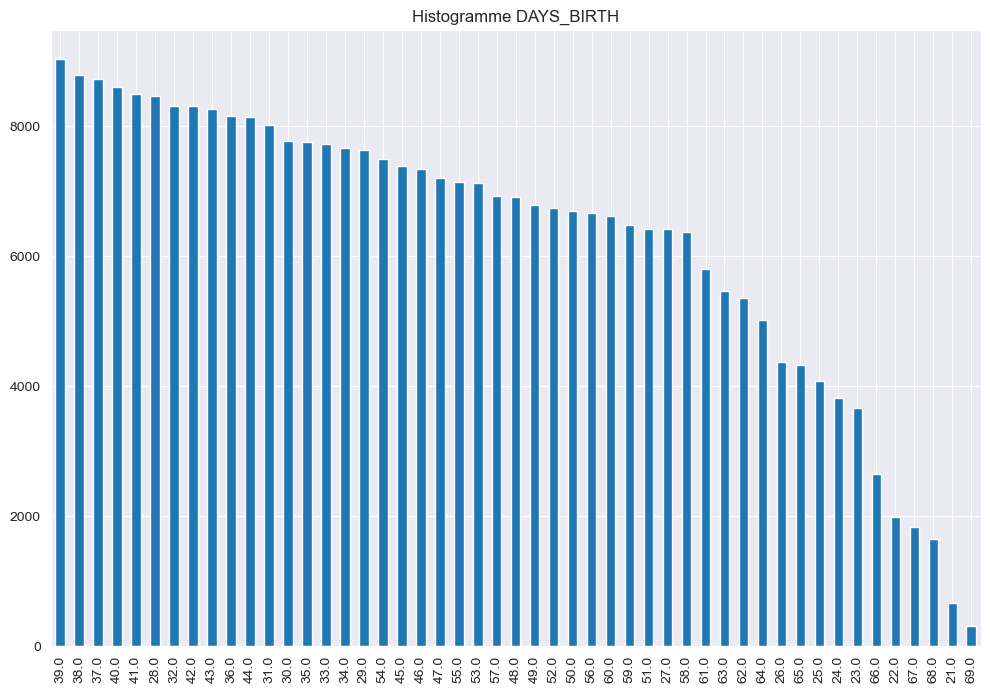

In [22]:
plt.figure(figsize=(12, 8))
data['DAYS_BIRTH'].value_counts().plot(kind='bar')
plt.title('Histogramme DAYS_BIRTH')
plt.xticks(rotation=90)
plt.show()

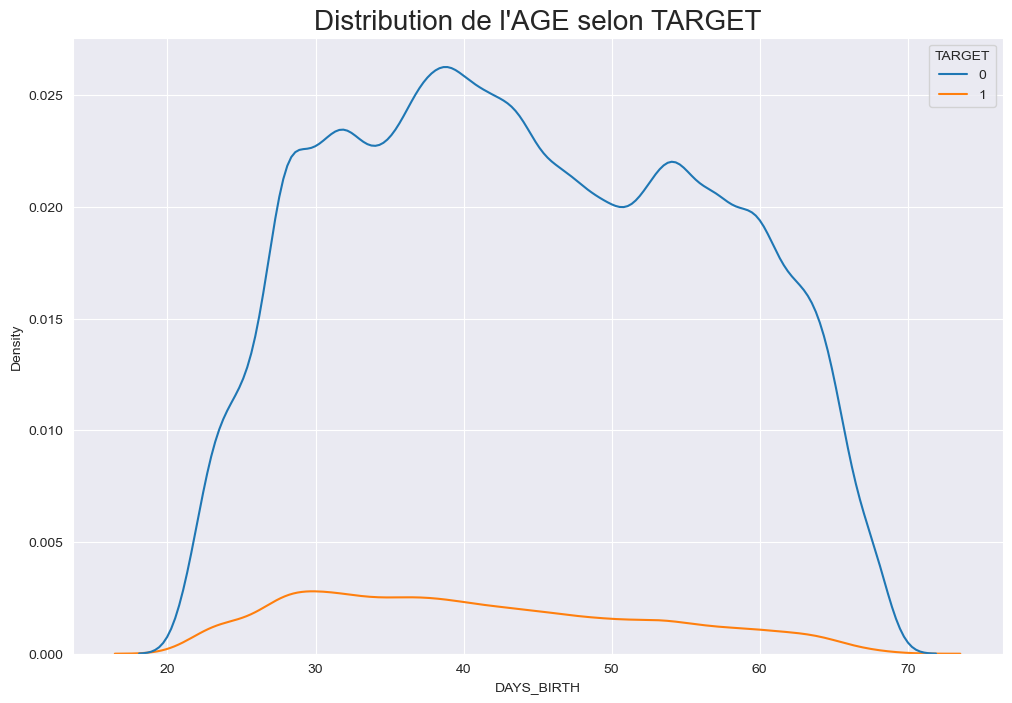

In [23]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data, x='DAYS_BIRTH', hue='TARGET')
plt.title("Distribution de l'AGE selon TARGET", fontsize=20)
plt.show()

In [24]:
#Colonnes avec taux >50% valeurs manquantes
cols_nan = data.isna().mean()[data.isna().mean()>0.5].index.tolist()

#Identification des variables numériques
num_cols = data.columns[~data.columns.isin(cat_cols)].tolist()
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

In [25]:
for c in ['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']+cols_nan:
    num_cols.remove(c)

# 4/ Modélisation

## 4.1/ Première recherche des meilleurs hyper-paramètres

In [18]:
#Création des classifieurs avec leurs paramètres
models = [
          {'name': 'Dummy Classifieur', 'clf': DummyClassifier(random_state=0)},
          {'name': 'Régression Logistique', 'clf': LogisticRegression(random_state=0)},
          {'name': 'Random Forest', 'clf': RandomForestClassifier(),
           'params': {'randomforestclassifier__random_state': [0],
                      'randomforestclassifier__n_estimators': [200],
                      'randomforestclassifier__max_depth': range(10, 20, 2)}},
          {'name': 'Decision Tree', 'clf': DecisionTreeClassifier(),
           'params': {'decisiontreeclassifier__random_state': [0],
                      'decisiontreeclassifier__max_depth': range(10, 20, 2)}},
          {'name': 'LGBM', 'clf': LGBMClassifier(),
           'params': {'lgbmclassifier__random_state': [0],
                      'lgbmclassifier__n_estimators': [200],
                      'lgbmclassifier__max_depth': range(2, 6), 
                      'lgbmclassifier__learning_rate': [0.01, 0.02, 0.03]}}
]

In [19]:
#Proportion de la variable cible
data['TARGET'].value_counts(normalize=True)

0    0.91927
1    0.08073
Name: TARGET, dtype: float64

In [20]:
#Création d'un échantillon (10%) en conservant la proportion des classes de la variable cible
id_1_sample = random.sample(data.loc[data['TARGET']==1, 'SK_ID_CURR'].tolist(), 
                            int(0.1*(len(data[data['TARGET']==1]))))
id_0_sample = random.sample(data.loc[data['TARGET']==0, 'SK_ID_CURR'].tolist(), 
                            int(0.1*(len(data[data['TARGET']==0]))))

data_sample = data[data['SK_ID_CURR'].isin(id_1_sample+id_0_sample)].copy()

X_sample = data_sample.drop(columns=['SK_ID_CURR', 'TARGET']+cols_nan).copy()
target_sample = data_sample['TARGET']

In [21]:
#Vérification de la proportion de la variable cible dans l'échantillon
data_sample['TARGET'].value_counts(normalize=True)

0    0.919285
1    0.080715
Name: TARGET, dtype: float64

In [22]:
#Création de la fonction de modélisation
def cls_function(models, X, target, num_cols):
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=0)
    #Création d'une pipeline pour standardiser uniquement les variables numérques
    process_pipeline = ColumnTransformer([('num', StandardScaler(), num_cols)],
                                         remainder='passthrough')

    models_details = []
    for model in models:
        if 'params' in model:
            clf = make_pipeline(process_pipeline, model['clf'])
            #Recherche des meilleurs paramètres et entrainement du classifieur
            grid = GridSearchCV(clf, param_grid=model['params'], cv=5, scoring='roc_auc')
            grid.fit(X_train, y_train)
        
            best_params = grid.best_params_
            best_model = grid.best_estimator_
            best_score = np.round(grid.best_score_, 2)
        
        else:
            best_model = make_pipeline(process_pipeline, model['clf'])
            best_model.fit(X_train, y_train)
            
            best_params = '-'
            best_score = np.round(roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]), 2)
        
        #Scores
        auc = np.round(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]), 2)
        
        f1_train = np.round(f1_score(y_train, best_model.predict(X_train)), 2)
        f1_test = np.round(f1_score(y_test, best_model.predict(X_test)), 2)
        
        recall_train = np.round(recall_score(y_train, best_model.predict(X_train)), 2)
        recall_test = np.round(recall_score(y_test, best_model.predict(X_test)), 2)
    
        cls_details = {'name': model['name'], 
                       'AUC_train': best_score, 'AUC_test': auc,
                       'f1_train': f1_train, 'f1_test': f1_test, 
                       'recall_train': recall_train, 'recall_test': recall_test,
                       'best_params': best_params}
        models_details.append(cls_details)
        
        print(f"Classifier: {model['name']}")
        print(f'AUC_train = {str(best_score)}, AUC_test = {str(auc)}')
        print(f'f1_train = {str(f1_train)}, f1_test = {str(f1_test)}')
        print(f'recall_train = {str(recall_train)}, recall_test = {recall_test}')
        #Matrice de confusion
        conf_matrix = confusion_matrix(y_test, best_model.predict(X_test))
        plt.figure()
        sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
        plt.show()
        
    models_summary = pd.DataFrame(models_details)
    return models_summary

Classifier: Dummy Classifieur
AUC_train = 0.5, AUC_test = 0.5
f1_train = 0.0, f1_test = 0.0
recall_train = 0.0, recall_test = 0.0


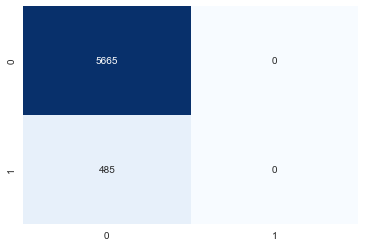

C:\Users\raflg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: Régression Logistique
AUC_train = 0.76, AUC_test = 0.75
f1_train = 0.04, f1_test = 0.03
recall_train = 0.02, recall_test = 0.01


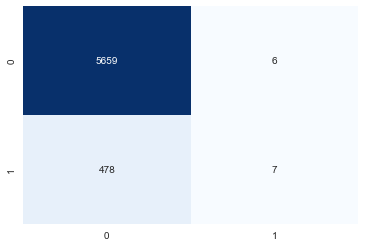

Classifier: Random Forest
AUC_train = 0.72, AUC_test = 0.74
f1_train = 0.0, f1_test = 0.0
recall_train = 0.0, recall_test = 0.0


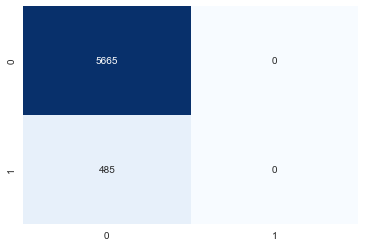

Classifier: Decision Tree
AUC_train = 0.66, AUC_test = 0.61
f1_train = 0.38, f1_test = 0.07
recall_train = 0.25, recall_test = 0.05


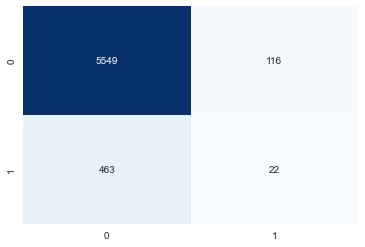

Classifier: LGBM
AUC_train = 0.74, AUC_test = 0.75
f1_train = 0.02, f1_test = 0.0
recall_train = 0.01, recall_test = 0.0


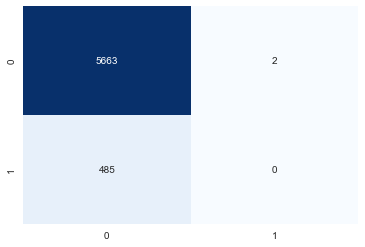

In [23]:
summary = cls_function(models, X_sample, target_sample, num_cols)

In [24]:
summary

,name,AUC_train,AUC_test,f1_train,f1_test,recall_train,recall_test,best_params
0,Dummy Classifieur,0.50,0.50,0.00,0.00,0.00,0.00,-
1,Régression Logistique,0.76,0.75,0.04,0.03,0.02,0.01,-
2,Random Forest,0.72,0.74,0.00,0.00,0.00,0.00,"{'randomforestclassifier__max_depth': 10, 'ran..."
3,Decision Tree,0.66,0.61,0.38,0.07,0.25,0.05,"{'decisiontreeclassifier__max_depth': 10, 'dec..."
4,LGBM,0.74,0.75,0.02,0.00,0.01,0.00,"{'lgbmclassifier__learning_rate': 0.03, 'lgbmc..."


## 4.2/ Ajustement de l'équilibre des classes
Utilisation du paramètres class_weight='balanced'

In [25]:
#Création des classifieurs avec leurs paramètres
models_balanced = [
    {'name': 'Régression Logistique', 'clf': LogisticRegression(random_state=0, class_weight='balanced')},
    {'name': 'Random Forest', 'clf': RandomForestClassifier(),
             'params': {'randomforestclassifier__random_state': [0],
                        'randomforestclassifier__n_estimators': [200],
                        'randomforestclassifier__max_depth': range(10, 20, 2),
                        'randomforestclassifier__class_weight': ['balanced']}},
    {'name': 'Decision Tree', 'clf': DecisionTreeClassifier(),
             'params': {'decisiontreeclassifier__random_state': [0],
                        'decisiontreeclassifier__max_depth': range(10, 20, 2),
                        'decisiontreeclassifier__class_weight': ['balanced']}},
    {'name': 'LGBM', 'clf': LGBMClassifier(),
             'params': {'lgbmclassifier__random_state': [0],
                        'lgbmclassifier__n_estimators': [200],
                        'lgbmclassifier__max_depth': range(2, 6), 
                        'lgbmclassifier__learning_rate': [0.01, 0.02, 0.03],
                        'lgbmclassifier__class_weight': ['balanced']}}
]

C:\Users\raflg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: Régression Logistique
AUC_train = 0.76, AUC_test = 0.75
f1_train = 0.27, f1_test = 0.26
recall_train = 0.69, recall_test = 0.66


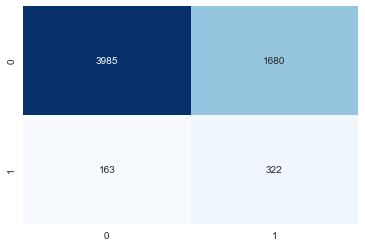

Classifier: Random Forest
AUC_train = 0.71, AUC_test = 0.74
f1_train = 0.52, f1_test = 0.27
recall_train = 0.79, recall_test = 0.38


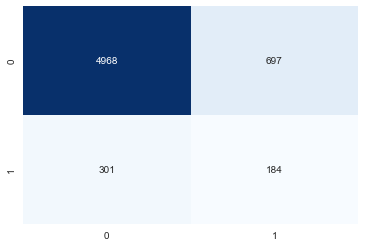

Classifier: Decision Tree
AUC_train = 0.63, AUC_test = 0.64
f1_train = 0.33, f1_test = 0.22
recall_train = 0.87, recall_test = 0.57


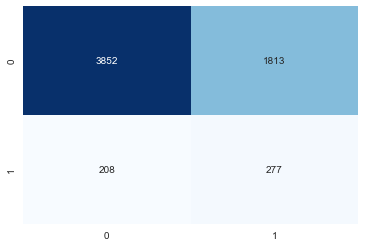

Classifier: LGBM
AUC_train = 0.74, AUC_test = 0.75
f1_train = 0.29, f1_test = 0.25
recall_train = 0.71, recall_test = 0.64


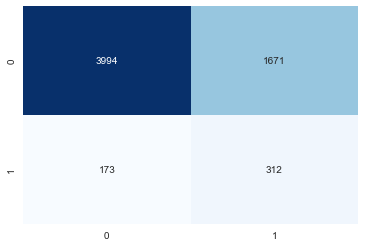

In [26]:
summary_balanced = cls_function(models_balanced, X_sample, target_sample, num_cols)

In [27]:
summary_balanced

,name,AUC_train,AUC_test,f1_train,f1_test,recall_train,recall_test,best_params
0,Régression Logistique,0.76,0.75,0.27,0.26,0.69,0.66,-
1,Random Forest,0.71,0.74,0.52,0.27,0.79,0.38,{'randomforestclassifier__class_weight': 'bala...
2,Decision Tree,0.63,0.64,0.33,0.22,0.87,0.57,{'decisiontreeclassifier__class_weight': 'bala...
3,LGBM,0.74,0.75,0.29,0.25,0.71,0.64,"{'lgbmclassifier__class_weight': 'balanced', '..."


## 4.3/ Choix du meilleur modèle
Classifier LGBM

In [28]:
#Meilleurs paramètres du LGBM
summary_balanced.loc[summary_balanced['name']=='LGBM', 'best_params'].tolist()

[{'lgbmclassifier__class_weight': 'balanced',
  'lgbmclassifier__learning_rate': 0.03,
  'lgbmclassifier__max_depth': 3,
  'lgbmclassifier__n_estimators': 200,
  'lgbmclassifier__random_state': 0}]

### Feature engineering

In [26]:
#Création de nouvelles variables
data['credit_annuity_ratio'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
data['credit_goods_price_ratio'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
data['credit_downpayment'] = data['AMT_GOODS_PRICE'] / data['AMT_CREDIT']

C:\Users\raflg\AppData\Local\Temp\ipykernel_12120\2013833287.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['credit_annuity_ratio'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
C:\Users\raflg\AppData\Local\Temp\ipykernel_12120\2013833287.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['credit_goods_price_ratio'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
C:\Users\raflg\AppData\Local\Temp\ipykernel_12120\2013833287.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

In [27]:
#Ajout des nouvelles variables à la liste des variables numériques
num_cols.append('credit_annuity_ratio')
num_cols.append('credit_goods_price_ratio')
num_cols.append('credit_downpayment')

In [31]:
#Création du LGBM avec ses paramètres
models_best = [
    {'name': 'LGBM', 'clf': LGBMClassifier(random_state=0, n_estimators=200, max_depth=3,
                                           learning_rate=0.03, class_weight='balanced')}
]

In [32]:
#Création d'un nouvel échantillon
id_sample = random.sample(data['SK_ID_CURR'].tolist(), int(0.1*(len(data))))
data_sample = data[data['SK_ID_CURR'].isin(id_sample)].copy()

X_sample = data_sample.drop(columns=['SK_ID_CURR', 'TARGET']+cols_nan).copy()
target_sample = data_sample['TARGET']

Classifier: LGBM
AUC_train = 0.79, AUC_test = 0.76
f1_train = 0.29, f1_test = 0.27
recall_train = 0.71, recall_test = 0.67


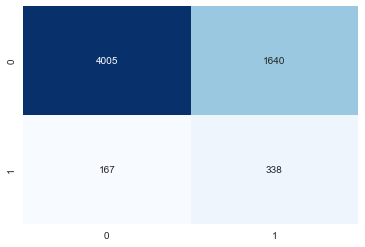

In [33]:
summary = cls_function(models_best, X_sample, target_sample, num_cols)

In [34]:
summary

,name,AUC_train,AUC_test,f1_train,f1_test,recall_train,recall_test,best_params
0,LGBM,0.79,0.76,0.29,0.27,0.71,0.67,-


### Feature selection

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

Optimal number of features : 50


C:\Users\raflg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


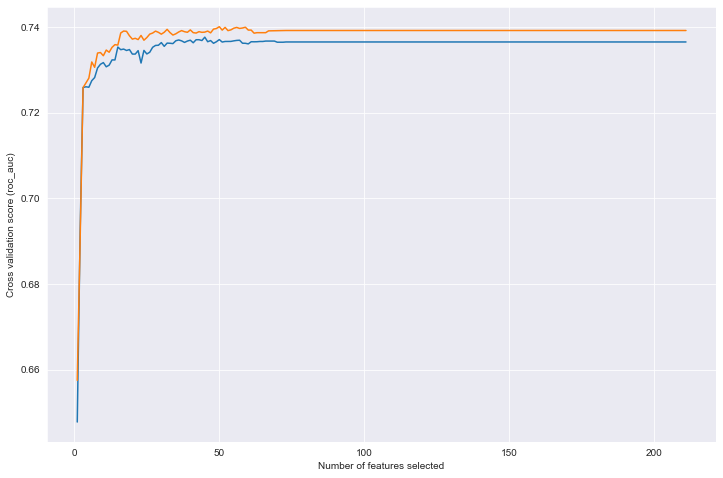

In [36]:
#Feature selection avec RFECV
model = LGBMClassifier(random_state=0, n_estimators=200, max_depth=3, learning_rate=0.03, class_weight='balanced')

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring='roc_auc', 
              min_features_to_select=1)
rfecv.fit(X_sample, target_sample)

print(f'Optimal number of features : {rfecv.n_features_}')

plt.figure(figsize=(12, 8))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (roc_auc)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [37]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X_sample.columns.tolist()
feature_importance_df['importance'] = rfecv.ranking_

In [38]:
#Récupération des variables optimales
features_selection = feature_importance_df.loc[feature_importance_df['importance']==1, 'feature'].tolist()

feat_sel = joblib.dump(features_selection, 'features_selection.joblib')

In [39]:
#Identification des variables numériques
new_num_cols = np.intersect1d(features_selection, num_cols).tolist()

### Entrainement du LGBM avec l'ensemble du jeu de données

In [41]:
X = data[features_selection].copy()
y = data['TARGET'].copy()

Classifier: LGBM
AUC_train = 0.75, AUC_test = 0.75
f1_train = 0.26, f1_test = 0.26
recall_train = 0.68, recall_test = 0.68


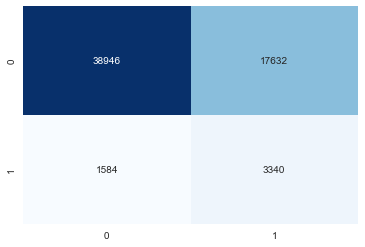

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

process_pipeline = ColumnTransformer([('num', StandardScaler(), new_num_cols)],
                                     remainder='passthrough')

lgbm_clf = LGBMClassifier(random_state=0, n_estimators=200, max_depth=3,
                          learning_rate=0.03, class_weight='balanced')
clf_pipeline = make_pipeline(process_pipeline, lgbm_clf)
clf_pipeline.fit(X_train, y_train)
            
best_score = np.round(roc_auc_score(y_train, clf_pipeline.predict_proba(X_train)[:, 1]), 2)
            
#Scores
auc = np.round(roc_auc_score(y_test, clf_pipeline.predict_proba(X_test)[:, 1]), 2)

f1_train = np.round(f1_score(y_train, clf_pipeline.predict(X_train)), 2)
f1_test = np.round(f1_score(y_test, clf_pipeline.predict(X_test)), 2)

recall_train = np.round(recall_score(y_train, clf_pipeline.predict(X_train)), 2)
recall_test = np.round(recall_score(y_test, clf_pipeline.predict(X_test)), 2)

print(f'Classifier: LGBM')
print(f'AUC_train = {str(best_score)}, AUC_test = {str(auc)}')
print(f'f1_train = {str(f1_train)}, f1_test = {str(f1_test)}')
print(f'recall_train = {str(recall_train)}, recall_test = {recall_test}')
conf_matrix = confusion_matrix(y_test, clf_pipeline.predict(X_test))
plt.figure()
sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.show()

In [43]:
#Création d'un dictionnaire des variables et leur type (model dynamique de l'API)
features_dict = X.dtypes.astype(str).to_dict()
    
joblib.dump(features_dict, 'C:/Users/raflg/fastapi-p7/p7_features_type.joblib')
joblib.dump(clf_pipeline, 'C:/Users/raflg/fastapi-p7/p7_pipeline.joblib')
joblib.dump(clf_pipeline, 'C:/Users/raflg/streamlit-p7/p7_pipeline.joblib')

['C:/Users/raflg/streamlit-p7/p7_pipeline.joblib']

# 5/ Création métrique métier

In [29]:
clf_pipeline = joblib.load('C:/Users/raflg/fastapi-p7/p7_pipeline.joblib')
features_selection = joblib.load('features_selection.joblib')

new_num_cols = np.intersect1d(features_selection, num_cols).tolist()

X = data[features_selection].copy()
y = data['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

C:\Users\raflg\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\raflg\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\raflg\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own ri

In [22]:
#Création du fbeta score avec beta=4
fbeta_train = np.round(fbeta_score(y_train, clf_pipeline.predict(X_train), beta=4), 2)
fbeta_test = np.round(fbeta_score(y_test, clf_pipeline.predict(X_test), beta=4), 2)

print('Classifier: LGBM')
print(f'Fbeta score train = {fbeta_train}')
print(f'Fbeta score test = {fbeta_test}')

Classifier: LGBM
Fbeta score train = 0.57
Fbeta score test = 0.57


# 6/ Recherche du seuil de décision

In [23]:
fbeta_scores = []
f1_scores = []
precision_scores = []
recall_scores =[]

for t in np.arange(0, 1, 0.05):
    y_threshold = np.where(clf_pipeline.predict_proba(X_test)[:,1] > t, 1, 0)
    fbeta = np.round(fbeta_score(y_test, y_threshold, beta=4), 2)
    fbeta_scores.append(fbeta)
    
    f1 = np.round(f1_score(y_test, y_threshold), 2)
    f1_scores.append(f1)
    
    precision = np.round(precision_score(y_test, y_threshold), 2)
    precision_scores.append(precision)
    
    recall = np.round(recall_score(y_test, y_threshold), 2)
    recall_scores.append(recall)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


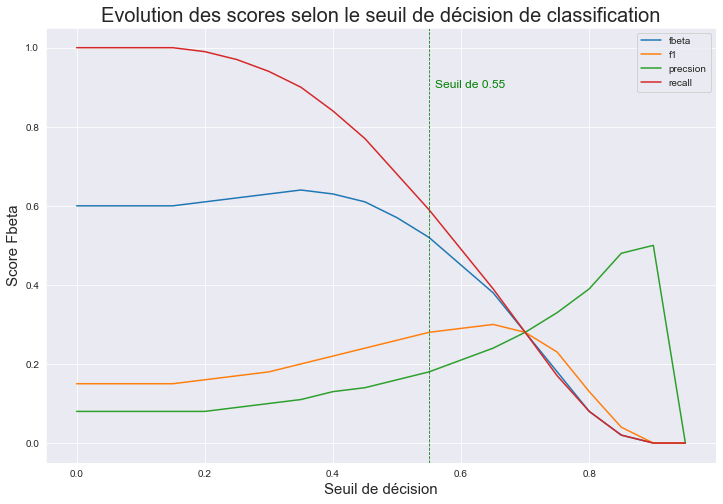

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, 1, 0.05), fbeta_scores)
plt.plot(np.arange(0, 1, 0.05), f1_scores)
plt.plot(np.arange(0, 1, 0.05), precision_scores)
plt.plot(np.arange(0, 1, 0.05), recall_scores)
plt.axvline(0.55, color='green', linestyle='--', linewidth=0.8)
plt.text(0.56, 0.9, 'Seuil de 0.55', color='green', fontsize=12)
plt.xlabel('Seuil de décision', fontsize=15)
plt.ylabel('Score Fbeta', fontsize=15)
plt.title('Evolution des scores selon le seuil de décision de classification', fontsize=20)
plt.legend(['fbeta', 'f1', 'precsion', 'recall'])
plt.show()

# 7/ Interprétation

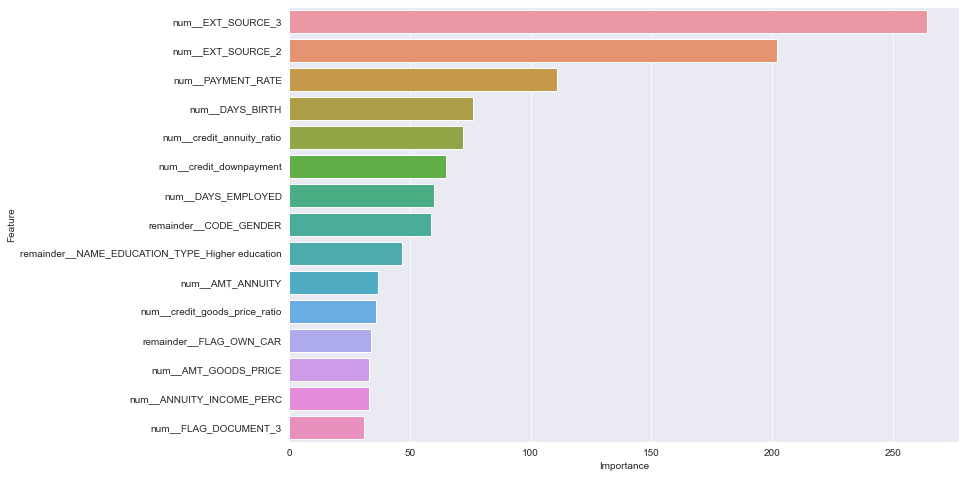

In [44]:
#Interprétation globale de l'importance des variables
features_imp = clf_pipeline.steps[1][1].feature_importances_
features_names = clf_pipeline[0].get_feature_names_out()

imp_df = pd.DataFrame()
imp_df['Feature'] = features_names
imp_df['Importance'] = features_imp

plt.figure(figsize=(12, 8))
sns.barplot(data=imp_df.sort_values(by='Importance', ascending=False).iloc[:15], 
            x='Importance', y='Feature')
plt.show()

In [30]:
import shap
shap.initjs()

In [37]:
shap.force_plot(explainer.expected_value[1], shap_values[1], subsampled_test_data, feature_names=X_test.columns)

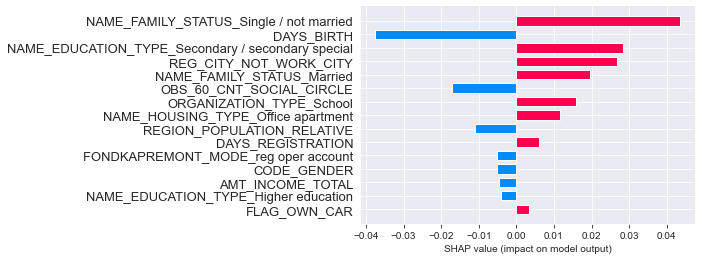

In [18]:
shap.bar_plot(shap_values[1][0], feature_names=X_train.columns, max_display=15)

# 8/ Jeu de données pour application Streamlit
Création d'un échantillon de 100 clients (variable TARGET équilibrée) pour le dashboard

In [52]:
def application_train(num_rows=None, nan_as_category=False):
    # Read data
    df = pd.read_csv('C:/Users/raflg/Downloads/OpenClassrooms/Projet 7/application_train.csv', nrows=num_rows)
    print(f'Train samples: {len(df)}')
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER']!='XNA']

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['DAYS_BIRTH'] = np.round(abs(df['DAYS_BIRTH']) /365, 0)
    return df

In [53]:
data_streamlit = application_train()
data_streamlit['credit_annuity_ratio'] = data_streamlit['AMT_CREDIT'] / data_streamlit['AMT_ANNUITY']
data_streamlit['credit_goods_price_ratio'] = data_streamlit['AMT_CREDIT'] / data_streamlit['AMT_GOODS_PRICE']
data_streamlit['credit_downpayment'] = data_streamlit['AMT_GOODS_PRICE'] / data_streamlit['AMT_CREDIT']

Train samples: 307511


In [54]:
sample_1 = random.sample(data_streamlit.loc[data_streamlit['TARGET']==1, 'SK_ID_CURR'].tolist(), 50)
sample_0 = random.sample(data_streamlit.loc[data_streamlit['TARGET']==0, 'SK_ID_CURR'].tolist(), 50)

data_streamlit_sample = data_streamlit[data_streamlit['SK_ID_CURR'].isin(sample_1+sample_0)]

features_selection.append('SK_ID_CURR')

data_ml_sample = data.loc[data['SK_ID_CURR'].isin(sample_1+sample_0), features_selection]

In [55]:
data_streamlit_sample.to_csv('C:/Users/raflg/streamlit-p7/data_sample.csv', index=False)
data_ml_sample.to_csv('C:/Users/raflg/streamlit-p7/data_ml_sample.csv', index=False)